In [1]:
import pandas as pd
import os
import scipy.stats as st
import numpy as np
import statsmodels.stats.multitest as smt
import seaborn as sns
import matplotlib.pyplot as plt

# OTU relative abundance

In [2]:
#Calculate relative abundance of each OTU

df_OTU = pd.read_csv("input/OTU_rarify.csv") #read in rarified OTU table

df_OTU_rel = df_OTU.copy()
relabun_dict=dict(zip([sample for sample in df_OTU_rel.columns],[df_OTU_rel[sample].sum() for sample in df_OTU_rel.columns])) # create a dictionary of the form (columnName:sum_of_all_column_entries)
relabun_dict.pop('#OTU ID')

df_OTU_rel.loc[:,'AL-BN-1':'WY-YN-5']=df_OTU_rel.loc[:,'AL-BN-1':'WY-YN-5'].div(relabun_dict,axis=1) #divide each entry by their respecive column sums
df_OTU_rel = df_OTU_rel.set_index('#OTU ID')
df_OTU_rel.to_csv("Output/OTU_rarify_relabun.csv")

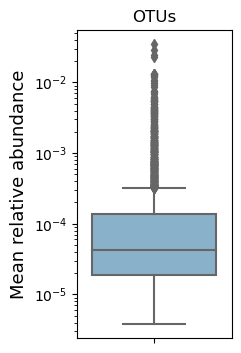

In [4]:
# plot the distribution of mean relative abundance of OTUs

relabun = df_OTU_rel.mean(axis=1)

plt.rcParams['figure.figsize'] = [2, 4]
ax = sns.boxplot(y = relabun, color='#7FB3D5')
ax.set_yscale('log')
plt.ylabel('Mean relative abundance', size=13)
plt.title('OTUs', size=12)
plt.savefig('output/OTU_mean_relabun.pdf', format='pdf', bbox_inches='tight', dpi=800)
plt.show()

# Classify abundant and rare taxa

In [49]:
# OTUs with mean relative abundance > 0.001 are classified as abundant taxa
# OTUs with mean relative abundance < 0.00002 are classified as rare taxa

Abundant_Taxa = []
Rare_Taxa = []
Neither_Taxa = []

for index, row in df_OTU_rel.iterrows():
    meanrelabun = row.mean()
    if meanrelabun > 0.001:
        Abundant_Taxa.append(index)
    elif meanrelabun <0.00002:
        Rare_Taxa.append(index)
    else:
        Neither_Taxa.append(index)


print("Abundant: ", len(Abundant_Taxa))
print("Rare: ", len(Rare_Taxa))
print("Neither: ", len(Neither_Taxa))

Abundant:  201
Rare:  870
Neither:  2087


In [50]:
# Save absolute and relative abundance for abundant and rare taxa

df_OTU = pd.read_csv("input/OTU_rarify.csv", index_col=0) #read in rarified OTU table

df_abun_abs = df_OTU[df_OTU.index.isin(Abundant_Taxa)]
df_abun_abs.to_csv("output/abun_abs.csv")

df_abun_relabun = df_OTU_rel[df_OTU_rel.index.isin(Abundant_Taxa)]
df_abun_relabun.to_csv("output/abun_relabun.csv")

df_rare_abs = df_OTU[df_OTU.index.isin(Rare_Taxa)]
df_rare_abs.to_csv("output/rare_abs.csv")

df_rare_relabun = df_OTU_rel[df_OTU_rel.index.isin(Rare_Taxa)]
df_rare_relabun.to_csv("output/rare_relabun.csv")

## Verify classification of abundant and rare taxa using MULTICOLA

In [55]:
df_OTU = pd.read_csv("input/OTU_rarify.csv") #read in rarified OTU table
df_taxon = pd.read_csv("input/OTU_taxon.csv")

# get taxanomy for each OTU
df_multicola = pd.merge(df_OTU, df_taxon, how='inner', left_on='#OTU ID', right_on='OTUs')
df_multicola=df_multicola.drop(columns=['OTUs'],axis=1)
df_multicola=df_multicola.rename(columns={'#OTU ID':'OTUs'})
df_multicola=df_multicola.set_index('OTUs')

In [ ]:
# Cross-check the mean relative abundance cutoffs above with MultiCoLA script in R. See directory "MultiCoLa"

# Classify generalists and specialists

In [60]:
otu = pd.read_csv('input/OTU_rarify.csv', index_col=0)

# calculate the proportion of OTUs in site i across all sites
otu = otu.div(otu.sum(axis=1), axis=0)

# calculate the Bn values
bn_ob = 1/otu.pow(2).sum(axis=1)

# shuffle dataframe rows for n times and calculate null Bn values for each OTU
n = 1000

bn_dic = {}
for i in range(n):
    rd = otu.sample(frac=1).reset_index(drop=True)
    bn = 1/rd.pow(2).sum(axis=1)
    bn_dic[i] = bn.values

bn_df = pd.DataFrame.from_dict(bn_dic)
bn_df.index = otu.index


# calculate p values for OTU's Bn larger and smaller than expectation
gen_pval = {}
spe_pval = {}

for idx, row in bn_df.iterrows():
    OTU_bn = bn_ob.loc[[idx]].values
    gen_pval[idx] = sum(i > OTU_bn[0] for i in list(row))/n
    spe_pval[idx] = sum(i < OTU_bn[0] for i in list(row))/n

# identify generalists and specialist
gen = dict((k, v) for k, v in gen_pval.items() if v < 0.05)
spe = dict((k, v) for k, v in spe_pval.items() if v < 0.05)

print(len(gen))
print(len(spe))

156
159


In [67]:
# Save absolute and relative abundance for generalists and specialists

df_OTU = pd.read_csv("input/OTU_rarify.csv", index_col=0) #read in rarified OTU table

df_gen_abs = df_OTU[df_OTU.index.isin(gen.keys())]
df_gen_abs.to_csv("output/gen_abs.csv")

df_gen_relabun = df_OTU_rel[df_OTU_rel.index.isin(gen.keys())]
df_gen_relabun.to_csv("output/gen_relabun.csv")

df_spe_abs = df_OTU[df_OTU.index.isin(spe.keys())]
df_spe_abs.to_csv("output/spe_abs.csv")

df_spe_relabun = df_OTU_rel[df_OTU_rel.index.isin(spe.keys())]
df_spe_relabun.to_csv("output/spe_relabun.csv")